In [1]:
'''
The script uses the selected features to run feature selection models:
1) hyperpatameter selection for original random forest model
2) feature selection for RFE-random forest and MC-random forest
3) model performance evaluation for RFE-RF and MC-RF

'''

In [2]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics import tsaplots

import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
from eofs.xarray import Eof

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point


from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

import pickle
import joblib

C:\Users\yzh086\Anaconda3\envs\work_env\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [5]:
### Import target and features ###

dataset = pd.read_csv(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\cluster_data\input_output.csv', index_col="Time")
dataset = dataset.drop(columns=['Unnamed: 0'])

dataset_temp = dataset.drop(index = '1919-12-01 00:00:00',axis = 1)
dataset_new = dataset_temp

feature_set = pd.read_csv(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\featureset\features.csv'
                    ,index_col=0)

In [106]:
### define dataset ##
X = feature_set.values # (3440, 235)
y = dataset_new.values.squeeze() # (3440,)

### find nan ###
np.where(np.isnan(X))
X[2770,152] = X[2769,152]
np.where(np.isnan(X))

(array([], dtype=int64), array([], dtype=int64))

In [127]:
### original random forest model -- feature importance ###
# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# define the model
model_test = RandomForestClassifier(n_estimators=111, max_depth = 13)
# fit the model
model_test.fit(X[:-30,:50], y[:-30])
# get importance
importance_test = model_test.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_test):
	print('Feature: %0d, Score: %.5f' % (i,v))


Feature: 0, Score: 0.01781
Feature: 1, Score: 0.01779
Feature: 2, Score: 0.01932
Feature: 3, Score: 0.01830
Feature: 4, Score: 0.02010
Feature: 5, Score: 0.01770
Feature: 6, Score: 0.01931
Feature: 7, Score: 0.01714
Feature: 8, Score: 0.01984
Feature: 9, Score: 0.01790
Feature: 10, Score: 0.01928
Feature: 11, Score: 0.01896
Feature: 12, Score: 0.01940
Feature: 13, Score: 0.02010
Feature: 14, Score: 0.02108
Feature: 15, Score: 0.02058
Feature: 16, Score: 0.02076
Feature: 17, Score: 0.01939
Feature: 18, Score: 0.01978
Feature: 19, Score: 0.01901
Feature: 20, Score: 0.01943
Feature: 21, Score: 0.02097
Feature: 22, Score: 0.01974
Feature: 23, Score: 0.02019
Feature: 24, Score: 0.01969
Feature: 25, Score: 0.01997
Feature: 26, Score: 0.01938
Feature: 27, Score: 0.01992
Feature: 28, Score: 0.02099
Feature: 29, Score: 0.02191
Feature: 30, Score: 0.01922
Feature: 31, Score: 0.01854
Feature: 32, Score: 0.01852
Feature: 33, Score: 0.01885
Feature: 34, Score: 0.01948
Feature: 35, Score: 0.01783
Fe

最大得分：0.5034883720930232 子树数量为：111


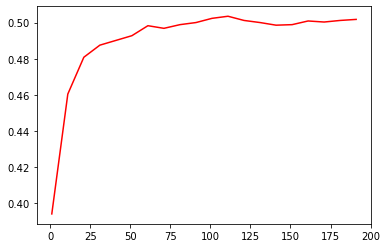

In [74]:
### hyperparameter selection for original random forest model-- number of tree ###
score_lt = []

for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1
                                ,random_state=90)
    score = cross_val_score(rfc, X, y, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('max score：{}'.format(score_max),
      'tree number：{}'.format(score_lt.index(score_max)*10+1))

# plot learning curve
x = np.arange(1,201,10)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

最大得分：0.5084302325581396 子树数量为：81


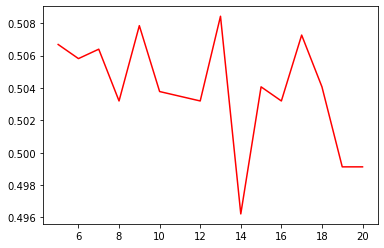

In [76]:
### hyperparameter selection for original random forest model -- max depth ###

score_lt = []

for i in range(5,21,1):
    rfc = RandomForestClassifier(n_estimators=111,max_depth=i
                                ,random_state=90)
    score = cross_val_score(rfc, X, y, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('max score：{}'.format(score_max),
      'tree number：{}'.format(score_lt.index(score_max)*10+1))

# plot learning curve
x = np.arange(5,21,1)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

In [107]:
### RFE-random forest for feature selection ###

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

'''
X, y = make_classification(n_samples=1000,
                           n_features=200,
                           n_informative=6,
                           n_redundant=10,
                           n_classes=2,
                           random_state=0
                          )
'''


rfecv = RFECV(estimator=RandomForestClassifier(n_estimators=111, max_depth = 13), 
              step=1, 
              cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimum number of features: %d" % rfecv.n_features_)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(max_depth=13, n_estimators=111),
      scoring='accuracy')

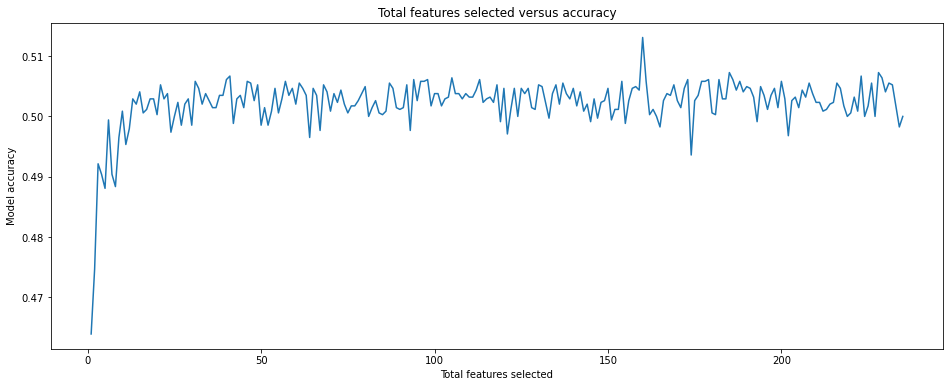

In [109]:
### visualize the RFE selection ###

plt.figure(figsize=(16, 6))
plt.title('Total features selected versus accuracy')
plt.xlabel('Total features selected')
plt.ylabel('Model accuracy')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [110]:
### rank the selected features and output final feature set from RFE-random forest model###

df_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])

for i in range(X.shape[1]):
    row = {'feature': i, 'support': rfecv.support_[i], 'ranking': rfecv.ranking_[i]}
    df_features = df_features.append(row, ignore_index=True)
    
df_features.sort_values(by='ranking').head(10)

feature_index = df_features[df_features['support']==True]['feature']

selected_feature = []
for i in range(len(np.array(feature_index))):
    selected_feature.append(feature_name[np.array(feature_index)[i]])
    
    
df_features_importance = pd.DataFrame(importance_test,index = selected_feature,columns = ['importance_score'])
features_importance_rank = df_features_importance.sort_values("importance_score",ascending=False, inplace=False)
feature_rank = pd.DataFrame(index = ['rank_score'],columns = feature_set.columns)
feature_set[selected_feature].to_csv(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\featureset\features_RFE_RF_160.csv')

C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_feat

C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_feat

C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_feat

C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_feat

C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_feat

C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_feat

C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
C:\Users\yzh086\AppData\Local\Temp/ipykernel_2180/2649121790.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_feat

,feature,support,ranking
117,117,True,1
108,108,True,1
109,109,True,1
110,110,True,1
111,111,True,1
112,112,True,1
113,113,True,1
114,114,True,1
115,115,True,1
116,116,True,1


In [367]:
### Monte carlo -- random forest to find out the optimal feature set ###
from sklearn.model_selection import KFold
import random

### first monte carlo random forest and get feature importance ranking ###
num_sim = 500
top_10 = 0
top_25 = 0
top_50 = 0
top_100 = 0

feature_rank2 = pd.DataFrame(np.zeros((1,235)), index = ['rank_score'],columns = feature_set.columns)

for k in range(num_sim):
    
    ### 160 features ###
    test_index = random.sample(range(0, 235), 160)
    selected_feature_temp = []
    for index in test_index:
        selected_feature_temp.append(feature_name[index])

    ## random forest feature selection ##

    ### define dataset ##
    X = feature_set[selected_feature_temp].values # (3440, 235)
    y = dataset_new.values.squeeze() # (3440,)

    ### find nan ###

    # define the model
    model_temp = RandomForestClassifier(n_estimators=111, max_depth = 13)
    # fit the model
    model_temp.fit(X[:,:], y[:])
    # get importance
    importance_temp = model_temp.feature_importances_

    ### allocate the rank score to certain feature ###

    df_features_importance = pd.DataFrame(importance_temp,index = selected_feature_temp,columns = ['importance_score'])
    features_importance_rank = df_features_importance.sort_values("importance_score",ascending=False, inplace=False)

    ## get the index of each feature as the rank number ##
    features_importance_rank_index = features_importance_rank.index.tolist() 
    
    # return the cumulative weights -- see if the feature importance score distinctive
    top_10 += features_importance_rank.values[:10].sum()
    top_25 += features_importance_rank.values[:25].sum()
    top_50 += features_importance_rank.values[:50].sum()
    top_100 += features_importance_rank.values[:100].sum()
    
    ## return the cumulative rank ##
    for i in range(235):
        if feature_rank2.columns[i] in features_importance_rank_index:

            rank_index = features_importance_rank_index.index(feature_rank2.columns[i])

            feature_rank2.iloc[:,i] += (rank_index+1)

        else:
            feature_rank2.iloc[:,i] += 160 ### depends on the number of features
            
# save features selected from MC-random forest #
df_final_rank2 = pd.DataFrame(final_rank2.values.reshape((-1,1)),index = feature_rank.columns,columns = ['importance_rank'])
features_final_rank2 = df_final_rank2.sort_values("importance_rank",ascending=True, inplace=False)

In [12]:
### Train RFE-random forest model with the optimal feature set ###
# selected features from RFE
rfe_feature = pd.read_csv(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\featureset\features_RFE_RF_160.csv'
                      ,index_col=0)
# rank the features
rfe_feature_rank = pd.DataFrame(model_rfe.feature_importances_,index = rfe_feature.columns,columns = ['importance_rank'])
rfe_features_final_rank = rfe_feature_rank.sort_values("importance_rank",ascending=False, inplace=False)

# top 25
rfe_25=rfe_features_final_rank.index[:25].to_list()
# top 50
rfe_50=rfe_features_final_rank.index[:50].to_list()

rfe_160 = rfe_feature.columns.to_list()

# train and test data
### define dataset ##
X_train = feature_set[rfe_160].values[:2580] # (3440, 235)
#X_train = feature_set.values[:2580] # (3440, 235)
y_train = dataset_new.values.squeeze()[:2580] # (3440,)
X_test = feature_set[rfe_160].values[2580:] # (3440, 235)
y_test = dataset_new.values.squeeze()[2580:] # (3440,)

### find nan ###
np.where(np.isnan(X_train))
np.where(np.isnan(X_test))

### random forest model -- feature importance ###
# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# define the model
model_rfe = RandomForestClassifier(n_estimators=111, max_depth = 13)
# fit the model -- train
model_rfe.fit(X_train[:,:], y_train[:])

(array([190], dtype=int64), array([108], dtype=int64))

In [112]:
### train the Monte Carlo--random model with the optimal feature set ###
# selected features from MC
MC_feature = pd.read_csv(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\featureset\features_MC_RF_160.csv'
                        ,index_col=0)
MC_feature_rank = pd.DataFrame(MC_feature.values.reshape((-1,1)),index = MC_feature.columns,columns = ['importance_rank'])
MC_features_final_rank = MC_feature_rank.sort_values("importance_rank",ascending=True, inplace=False)
# top 25
MC_25=MC_features_final_rank.index[:25].to_list()
# top 50
MC_50=MC_features_final_rank.index[:50].to_list()

MC_160 = MC_features_final_rank.index.to_list()
# train and test data
### define dataset ##
X_train = feature_set[MC_160].values[:2580] # (3440, 235)
y_train = dataset_new.values.squeeze()[:2580] # (3440,)

X_test = feature_set[MC_160].values[2580:] # (3440, 235)
y_test = dataset_new.values.squeeze()[2580:] # (3440,)
### find nan ###
np.where(np.isnan(X_train))
np.where(np.isnan(X_test))
#X[2770,152] = X[2769,152]
#np.where(np.isnan(X))
X_test[190,133] = X_test[189, 133]

### random forest model -- feature importance ###
# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# define the model
model_mc = RandomForestClassifier(n_estimators=251, max_depth = 6,max_features=15)
# fit the model -- train
model_mc.fit(X_train[:,:], y_train[:])

In [61]:
### visualize the model evaluation ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [63]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [96]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [65]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [66]:
y_pred = model_rfe.predict(X_test)

y_proba = model_rfe.predict_proba(X_test)

classes = model_rfe.classes_

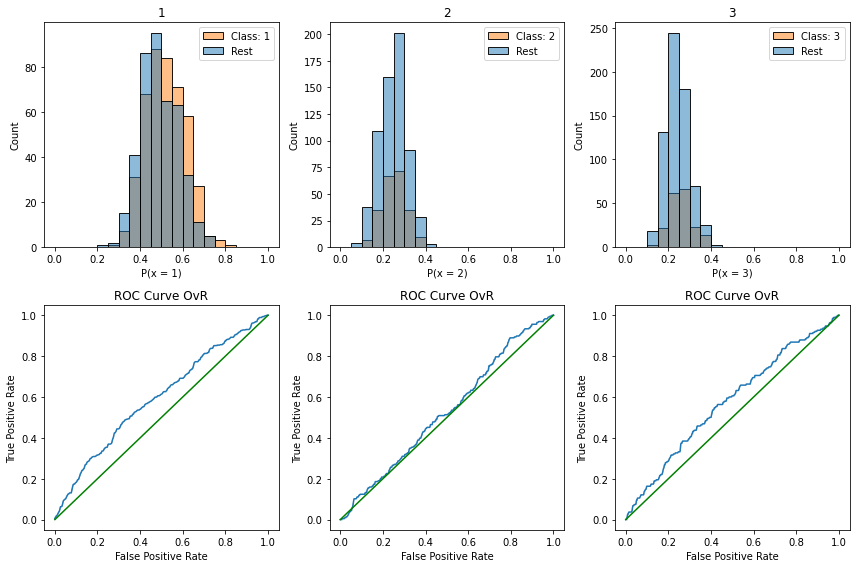

In [104]:
## ROC and AUC curve for multi-class problem

## OvR method for RFE-RF and MC-RF ##

# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = model_rfe.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots

    df_aux = pd.DataFrame(columns=['class','prob'])
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()
